In [24]:
import matplotlib.pyplot as plt
import numpy as np

AttributeError: 'numpy.ndarray' object has no attribute 'convert'

In [44]:

XLIM = 850;
YLIM = 850;
XSTEP = 850/5;
YSTEP = 850/5;

# AP Record Format
# Rectangle [X0, Y0, dX, dY]
AP_data = [
    [0,0, 3,3],
    [0,5, 3,3],
    [0,10,3,3],
]

# 
def export_EDIF(data):
    d = '';
    for line in data:
        d = d + "(figure AP (rectangle (pt {X0:d} {Y0:d}) (pt {X1:d} {Y1:d})))\n".format(X0=line[0], Y0=line[1], X1=line[0]+line[2], Y1=line[1]+line[3])
    return d;
    

In [23]:
print(export_EDIF(AP_data))

(figure AP (rectangle (pt 0 0) (pt 3 3)))
(figure AP (rectangle (pt 0 5) (pt 3 8)))
(figure AP (rectangle (pt 0 10) (pt 3 13)))



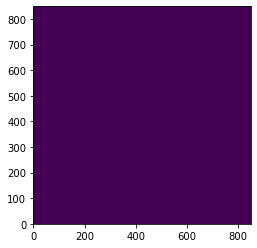

In [43]:
plt.imshow(np.multiply(255,b),origin='lower')

In [146]:
# GDSII I/O Test
from gdsii.library import Library
from gdsii.elements import *
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [90]:
# read a library from a file
with open('AL_AP_artwork_test.gds', 'rb') as stream:
    lib = Library.load(stream)
# let's move the first structure to a new library
# new_lib = Library(5, b'NEWLIB.DB', 1e-9, 0.001)
struc = lib.pop(0) # libraries and structures are derived from list class
# new_lib.append(struc)
 

In [409]:
lib.masks

In [390]:
def blit(dest, src, loc):
    pos = [i if i >= 0 else None for i in loc]
    neg = [-i if i < 0 else None for i in loc]
    target = dest[[slice(i,None) for i in pos]]
    src = src[[slice(i, j) for i,j in zip(neg, target.shape)]]
    target[[slice(None, i) for i in src.shape]] = src
    return dest

In [91]:
s1 = struc.copy()

In [395]:
e1 = s1[0]

In [402]:
e1.xy

[(205000, 985000),
 (208000, 985000),
 (208000, 988000),
 (205000, 988000),
 (205000, 985000)]

<ipython-input-390-beb2877c9526>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  target = dest[[slice(i,None) for i in pos]]
<ipython-input-390-beb2877c9526>:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  src = src[[slice(i, j) for i,j in zip(neg, target.shape)]]
<ipython-input-390-beb2877c9526>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in a

2050.0 9850.0 2080.0 9880.0
2000.0 9850.0 2030.0 9880.0
1950.0 9850.0 1980.0 9880.0
1900.0 9850.0 1930.0 9880.0
1850.0 9850.0 1880.0 9880.0
1800.0 9850.0 1830.0 9880.0
1750.0 9850.0 1780.0 9880.0
1700.0 9850.0 1730.0 9880.0
1650.0 9850.0 1680.0 9880.0
1600.0 9850.0 1630.0 9880.0
1550.0 9850.0 1580.0 9880.0
1500.0 9850.0 1530.0 9880.0
1450.0 9850.0 1480.0 9880.0
1400.0 9850.0 1430.0 9880.0
1350.0 9850.0 1380.0 9880.0
1300.0 9850.0 1330.0 9880.0
1250.0 9850.0 1280.0 9880.0
1200.0 9850.0 1230.0 9880.0
1750.0 9900.0 1780.0 9930.0
1800.0 9900.0 1830.0 9930.0
1850.0 9900.0 1880.0 9930.0
1900.0 9900.0 1930.0 9930.0
1950.0 9900.0 1980.0 9930.0
2000.0 9900.0 2030.0 9930.0
2050.0 9900.0 2080.0 9930.0
2100.0 9900.0 2130.0 9930.0
2150.0 9900.0 2180.0 9930.0
2200.0 9900.0 2230.0 9930.0
1700.0 9900.0 1730.0 9930.0
1650.0 9900.0 1680.0 9930.0
1600.0 9900.0 1630.0 9930.0
1550.0 9900.0 1580.0 9930.0
1500.0 9900.0 1530.0 9930.0
1450.0 9900.0 1480.0 9930.0
1400.0 9900.0 1430.0 9930.0
1350.0 9900.0 1380.0

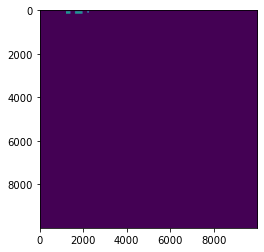

In [392]:
b = np.zeros((10000,10000));
for s in s1:
    x0 = s.xy[0][0]/100;
    y0 = s.xy[0][1]/100;
    x1 = s.xy[2][0]/100;
    y1 = s.xy[2][1]/100;
    APbox = np.ones((int(x1-x0),int(y1-y0)));
    b = blit(b, APbox, (int(y0),int(x0)));
    print(x0,y0,x1,y1);
b = np.flipud(np.dot(b,256));
plt.imshow(b);
plt.imsave('GDS_render.png',b);

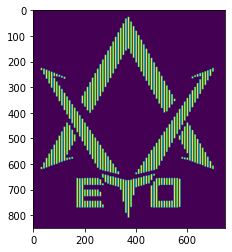

In [404]:
imgname = 'ETO'

k = Image.open(imgname+'.png').convert('L')
ksize = k.size
k_target_h = 85; # Unit is 5 um
k_scaling  = k_target_h/ksize[1]
ksize1 = np.dot(ksize,k_scaling).astype(int)
ksize2 = [ksize1[0],    ksize1[1]*10]
ksize3 = [ksize1[0]*10, ksize1[1]*10]
kr = k.resize(ksize2)
kr = kr.resize(ksize3,Image.NEAREST)
ka1 = (np.array(kr)>128).transpose()
kd = np.zeros(ksize2);
# KA1 UNIT: 0.5um
for i in range(ksize3[0]):
    if((i%10)==0):
        iq = int(i/10);
        # GAP FILLING
        # The problem with this approach is that the gap tend to get shifted to one direction
        # Consider a sliding-window approach if that's causing trouble
        #
        # Unit: 0.5um
        # DRC Rule requires that AP gap must > 2um    
        gap_counter = 4
        gap_pol = 0;
        for j in range(ksize3[1]):
            pixel = ka1[iq*10][j]
            if(pixel):
                if(gap_pol):
                    # The gap was bright
                    kd[iq][j]   = 255
                    gap_counter = gap_counter + 1
                else:
                    # The gap was dark
                    if((gap_counter>=4)):
                        # Flip to the bright side
                        kd[iq][j]   = 255
                        gap_counter = 0
                        gap_pol     = 1
                    else:
                        # Stay in the dark
                        kd[iq][j]   = 0
                        gap_counter = gap_counter + 1
            else :
                if(gap_pol):
                    # The gap was bright
                    if((gap_counter>=6)):
                        # Flip to the dark side
                        kd[iq][j]   = 0
                        gap_counter = 0
                        gap_pol     = 0
                    else:
                        # Stay in the light
                        kd[iq][j]   = 255
                        gap_counter = gap_counter + 1
                else:
                    # The gap was dark
                    kd[iq][j]   = 0
                    gap_counter = gap_counter + 1
                
    if((i%10)>=6):
        ka1[i] = 0
        
ka1 = ka1.transpose()
#plt.imshow(ka1)
#plt.imsave('AMK_conv.png',ka1);

kd_pil = np.array(Image.fromarray(np.uint8(kd.transpose())).resize(ksize3, Image.NEAREST)).transpose()

for i in range(ksize3[0]):
    if((i%10)>=6):
        kd_pil[i] = 0
kd_pil = kd_pil.transpose()
plt.imshow(kd_pil)
plt.imsave(imgname+'_conv.png',kd_pil);

# Image.fromarray(ka1)

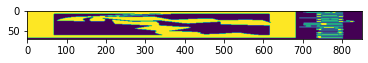

In [368]:
plt.imshow(kd)

DIV FACTOR: 42
DIV FACTOR: 42


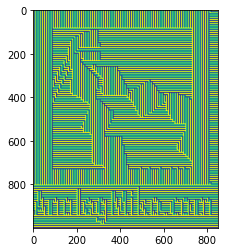

In [383]:
# Constant Spacing
imgname = 'AMK'
gapsize = 1;
k = Image.open(imgname+'.png').convert('L')
ksize = k.size
k_target_h = 85; # Unit is 5 um
k_scaling  = k_target_h/ksize[0]
ksize1 = np.dot(ksize,k_scaling).astype(int)
ksize2 = [ksize1[0],    ksize1[1]*10]
ksize3 = [ksize1[0]*10, ksize1[1]*10]
kr = np.array(k.resize(ksize1))
kr_dithered = (dither(kr, k_stucki,16)<<2);
kr_ditq = (dither(kr, k_stucki,16)<<2)>128;
strel = np.ones((gapsize, gapsize))
kr_ditq_di = ~binary_dilation(kr_ditq, structure=strel)

kr_dithered_10x   = np.array(Image.fromarray(kr_ditq).resize(ksize3,Image.NEAREST))
kr_dithered_10x_i = np.array(Image.fromarray(kr_ditq_di).resize(ksize3,Image.NEAREST))

kr_dithered_10x = kr_dithered_10x.transpose()
for i in range(ksize3[0]):
    if((i%10)>=6):
        kr_dithered_10x[i] = 0
kr_dithered_10x = kr_dithered_10x.transpose()


for i in range(ksize3[1]):
    if((i%10)>=6):
        kr_dithered_10x_i[i] = 0
kr_final = kr_dithered_10x + kr_dithered_10x_i;

plt.imshow(kr_final)
plt.imsave(imgname+'_hv.png',kr_final)
kr_dithered_10x_i = np.array(Image.fromarray(kr_dithered).resize(ksize3))

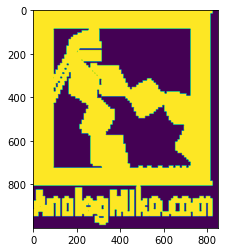

In [334]:
## kr_dithered_10x
import numpy as np
from scipy.ndimage.morphology import binary_dilation
strel = np.ones((4, 4))
dilated = binary_dilation(kr_dithered_10x_i, structure=strel)
plt.imshow(dilated)

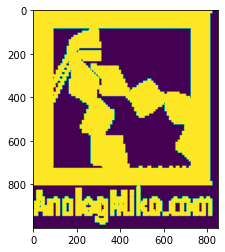

In [328]:
## GDS Write to new library and save
with open('Output.gds', 'wb') as stream:
    lib.save(stream)
with open('Output2.gds', 'wb') as stream:
    new_lib.save(stream)
    
    

In [279]:
import sys
import os
import numpy as np
from PIL import Image
from math import sqrt

k_fs = [
        0,0,0,7,0,
        0,3,5,1,0,
        0,0,0,0,0
    ]


k_jjn = [
        0,0,0,7,5,
        3,5,7,5,3,
        1,3,5,3,1
    ]


k_stucki = [
        0,0,0,8,4,
        2,4,8,4,2,
        1,2,4,2,1
    ]


k_s2 = [
        0,0,0,4,3,
        1,2,3,2,1,
        0,0,0,0,0
    ]

k_s3 = [
        0,0,0,5,3,
        2,4,5,4,2,
        0,2,3,2,0
    ]

k_s24a = [
        0,0,0,2,0,
        0,1,1,0,0,
        0,0,0,0,0
    ]


def dither(image, kernel, strength=1):
    pixels = image.copy()>>2
    xl = pixels.shape[0]
    yl = pixels.shape[1]

    DIV_FACTOR = sum(kernel)
    print("DIV FACTOR:", DIV_FACTOR)
    for y in range(yl):
        for x in range(xl):
            oldpixel = pixels[x][y]
            newpixel = 63*(oldpixel>31)
            pixels[x][y] = newpixel
            quant_error = (oldpixel - newpixel)/strength

            if (x<xl-1):
                pixels[x+1][y]   += quant_error*kernel[3]/DIV_FACTOR
            if (x<xl-2):
                pixels[x+2][y]   += quant_error*kernel[4]/DIV_FACTOR
                
            if (y<yl-1):
                if (x>1):
                    pixels[x-2][y+1] += quant_error*kernel[5]/DIV_FACTOR
                if (x>0):
                    pixels[x-1][y+1] += quant_error*kernel[6]/DIV_FACTOR
                    pixels[x][y+1]   += quant_error*kernel[7]/DIV_FACTOR
                if (x<xl-1):
                    pixels[x+1][y+1] += quant_error*kernel[8]/DIV_FACTOR
                if (x<xl-2):
                    pixels[x+2][y+1] += quant_error*kernel[9]/DIV_FACTOR
                
            if (y<yl-2):
                if (x>1):
                    pixels[x-2][y+2] += quant_error*kernel[10]/DIV_FACTOR
                if (x>0):
                    pixels[x-1][y+2] += quant_error*kernel[11]/DIV_FACTOR
                    pixels[x][y+2]   += quant_error*kernel[12]/DIV_FACTOR
                if (x<xl-1):
                    pixels[x+1][y+2] += quant_error*kernel[13]/DIV_FACTOR
                if (x<xl-2):
                    pixels[x+2][y+2] += quant_error*kernel[14]/DIV_FACTOR
 
    return pixels


filename = 'AMK.png'
ai = np.array(Image.open(filename).convert('L'),"int16")
img = Image.fromarray(dither(ai, k_stucki,2)<<2)
img.show()

# Note: Stucki is one of the few that can work with pure integer

DIV FACTOR: 42
